In [1]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import f1_score
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
class Hparams:
    def __init__(self, train_batch_size=64, test_batch_size=64, learning_rate=0.001, num_epochs=10, val_split=0.15, test_split=0.15, model_path='saved_model', dataset_path='/kaggle/input/imagesoasis/Data'):
        self.train_batch_size = train_batch_size
        self.test_batch_size = test_batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.val_split = val_split
        self.test_split = test_split
        self.model_path = model_path
        self.dataset_path = dataset_path

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
            mean = torch.mean(x)
            std = torch.std(x)
        return x, mean, std, y
    
    def __len__(self):
        return len(self.subset)

In [4]:
def get_transforms():
    transform = transforms.Compose([
        transforms.Resize((248, 248)),
        transforms.ToTensor(),
    ])

    return transform

In [5]:
def get_sample_weights(dataset, train_dataset):
    
    # Code taken from:
    #     https://www.maskaravivek.com/post/pytorch-weighted-random-sampler/
    y_train_indices = train_dataset.indices
    y_train = [dataset.targets[i] for i in y_train_indices]
    
    class_sample_counts = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
    
    weights = 1. / class_sample_counts
    sample_weights = np.array([weights[t] for t in y_train])
    sample_weights = torch.from_numpy(sample_weights)
    
    return sample_weights

In [6]:
def get_data_loaders(hparams):
    # Loading the dataset
    dataset = datasets.ImageFolder(hparams.dataset_path,
                                   transform=transforms.Compose([transforms.Grayscale()]))
    
    # Splitting dataset into train, validation and test partitions.
    proportions = [(1 - hparams.val_split - hparams.test_split), hparams.val_split, hparams.test_split]
    lengths = [int(p * len(dataset)) for p in proportions]
    lengths[-1] = len(dataset) - sum(lengths[:-1])
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, lengths)
    
    print(f'train size: {lengths[0]}, val size: {lengths[1]}, test size: {lengths[2]}')
    
    data_transforms = {
        'train': get_transforms(),
        'test': get_transforms()
    }
    
    # Using WeightedRandomSampler to overcome unbalance problem
    sample_weights = get_sample_weights(dataset, train_dataset)
    train_sampler = torch.utils.data.sampler.WeightedRandomSampler(sample_weights.type('torch.DoubleTensor'), len(sample_weights))
    
    train_dataset = CustomDataset(train_dataset, transform=data_transforms['train'])
    val_dataset = CustomDataset(val_dataset, transform=data_transforms['test'])
    test_dataset = CustomDataset(test_dataset, transform=data_transforms['test'])
    
    # Creating loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams.train_batch_size, sampler=train_sampler, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams.train_batch_size, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=hparams.test_batch_size)

    return train_loader, val_loader, test_loader

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, mid_channel, out_channel):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channel, mid_channel, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(mid_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(mid_channel, out_channel, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channel)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        
        x = self.pool(x)
        
        return x

In [8]:
class LinearBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        
        self.fc = nn.Linear(in_channel, out_channel)
        self.batch_norm = nn.BatchNorm1d(out_channel)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        
        return x

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.convblock1 = ConvBlock(1, 32, 64)
        self.convblock2 = ConvBlock(64, 128, 128)
        self.convblock3 = ConvBlock(128, 256, 256)
        self.convblock4 = ConvBlock(256, 512, 512)
        
        self.flatten = nn.Flatten(start_dim=1)
        
        self.linearblock1 = LinearBlock(512 * 15 * 15, 1024)
        self.linearblock2 = LinearBlock(1024, 512)
        self.linearblock3 = LinearBlock(512, 16)
        
        self.linearblock4 = LinearBlock(16 + 2, 4)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, img, mean, std):
        x = self.convblock1(img)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        
        x = self.flatten(x)
        
        x = self.linearblock1(x)
        x = self.linearblock2(x)
        x = self.linearblock3(x)
        
        x = torch.concat([x, mean.unsqueeze(1), std.unsqueeze(1)], dim=-1)
        x = self.linearblock4(x)
        x = self.softmax(x)
        
        return x

In [10]:
def train(model, train_loader, criterion, optimizer, device, epoch, num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    batch_size = 0

    targets, preds = [], []

    for batch_idx, (img, mean, std, target) in train_loader:
        img, mean, std, target = img.to(device), mean.to(device), std.to(device), target.to(device)
        batch_size = len(img)

        optimizer.zero_grad()
        output = model(img, mean, std)
        loss = criterion(output, target)
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)

        targets.append(target.cpu().numpy())
        preds.append(pred.cpu().numpy().flatten())

        train_correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()

        train_loader.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        train_loader.set_postfix(loss=train_loss / ((batch_idx+1) * len(img)), accuracy=100. * train_correct / ((batch_idx+1) * len(img)))

    targets = np.concatenate(targets)
    preds = np.concatenate(preds)
    f1 = f1_score(targets, preds, average='macro')

    train_length = train_loader.total * batch_size
    train_loss /= train_length
    train_accuracy = 100. * train_correct / train_length
    return train_loss, train_accuracy, f1

In [11]:
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    val_correct = 0
    total_size = 0
    with torch.no_grad():
        for batch_idx, (img, mean, std, target) in enumerate(val_loader):
            img, mean, std, target = img.to(device), mean.to(device), std.to(device), target.to(device)
            batch_size = len(img)
            output = model(img, mean, std)
            loss = criterion(output, target)
            val_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            val_correct += pred.eq(target.view_as(pred)).sum().item()
            
            total_size += len(img)
    val_loss /= total_size
    val_accuracy = 100. * val_correct / total_size
    return val_loss, val_accuracy

In [12]:
def predict(model, data_loader, criterion, device, eval=False):
    model.eval()
    pred_loss = 0
    pred_correct = 0
    total_size = 0

    predictions = torch.IntTensor()
    ground_truths = torch.IntTensor()

    predictions, ground_truths = predictions.to(device), ground_truths.to(device)

    with torch.no_grad():
        for batch_idx, (img, mean, std, target) in enumerate(data_loader):
            img, mean, std, target = img.to(device), mean.to(device), std.to(device), target.to(device)
            output = model(img, mean, std)
            loss = criterion(output, target)
            pred_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            pred_correct += pred.eq(target.view_as(pred)).sum().item()

            predictions = torch.cat((predictions, pred), dim=0)
            ground_truths = torch.cat((ground_truths, target), dim=0)
            
            total_size += len(img)
    
    pred_loss /= total_size
    pred_accuracy = 100. * pred_correct / total_size

    if eval:
        return pred_loss, pred_accuracy, predictions.cpu().numpy(), ground_truths.cpu().numpy()
    else:
        return predictions.cpu().numpy(), ground_truths.cpu().numpy()

In [13]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, early_stopping=None):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        loop = tqdm(enumerate(train_loader), total=len(train_loader), ascii=' >=')
        train_loss, train_accuracy, f1 = train(model, loop, criterion, optimizer, device, epoch, num_epochs)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if early_stopping is not None:
            early_stopping(val_accuracy)

            if early_stopping.early_stop:
                tqdm.write(f'\t => train_f1={f1:.4f}, val_loss={val_loss:.4f}, val_acc={val_accuracy:.4f}')
                print(f'Early stopping at Epoch {epoch+1}')
                break

        tqdm.write(f'\t => train_f1={f1:.4f}, val_loss={val_loss:.4f}, val_acc={val_accuracy:.4f}')

    return train_losses, train_accuracies, val_losses, val_accuracies

In [14]:
class EarlyStopping:
    def __init__(self, patience=5, mode='max'):
        self.counter = 0
        self.patience = patience
        self.early_stop = False
        self.mode = mode

        if self.mode == 'max':
            self.ref_value = float('-inf')
        elif self.mode == 'min':
            self.ref_value = float('inf')
        else:
            raise Exception(f'Undefined mode for EarlyStopping - mode: {mode}\n'
                             'Available modes are ["max", "min"]')

    def __call__(self, value):
        if self.mode == 'max':
            if value <= self.ref_value:
                self.counter += 1
            else:
                self.counter = 0
                self.ref_value = value
        elif self.mode == 'min':
            if value >= self.ref_value:
                self.counter += 1
            else:
                self.counter = 0
                self.ref_value = value

        if self.counter == self.patience:
            self.early_stop = True

In [15]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [16]:
def plot_accuracies(train_accuracies, val_accuracies):
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device.")

Using cuda device.


In [18]:
hparams = Hparams()

In [19]:
train_loader, val_loader, test_loader = get_data_loaders(hparams)

train size: 60505, val size: 12965, test size: 12967


In [20]:
early_stopping = EarlyStopping(patience=3, mode='max')

In [21]:
model = CNN().to(device)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hparams.learning_rate)

In [23]:
train_losses, train_accuracies, val_losses, val_accuracies = train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=hparams.num_epochs, early_stopping=early_stopping)

Epoch [1/10]: 100%|==========| 945/945 [14:28<00:00,  1.09it/s, accuracy=94.7, loss=0.0143]


	 => train_f1=0.9466, val_loss=0.0133, val_acc=94.2141


Epoch [2/10]: 100%|==========| 945/945 [14:25<00:00,  1.09it/s, accuracy=99.2, loss=0.0123]


	 => train_f1=0.9919, val_loss=0.0122, val_acc=98.6386


Epoch [3/10]: 100%|==========| 945/945 [14:22<00:00,  1.10it/s, accuracy=99.3, loss=0.012] 


	 => train_f1=0.9927, val_loss=0.0120, val_acc=98.8011


Epoch [4/10]: 100%|==========| 945/945 [14:22<00:00,  1.10it/s, accuracy=99.5, loss=0.0118]


	 => train_f1=0.9954, val_loss=0.0117, val_acc=99.7834


Epoch [5/10]: 100%|==========| 945/945 [14:31<00:00,  1.08it/s, accuracy=99.6, loss=0.0118]


	 => train_f1=0.9960, val_loss=0.0118, val_acc=99.1259


Epoch [6/10]: 100%|==========| 945/945 [14:22<00:00,  1.10it/s, accuracy=99.4, loss=0.0118]


	 => train_f1=0.9943, val_loss=0.0117, val_acc=99.5668


Epoch [7/10]: 100%|==========| 945/945 [14:22<00:00,  1.10it/s, accuracy=99.7, loss=0.0117]


	 => train_f1=0.9973, val_loss=0.0117, val_acc=99.6597
Early stopping at Epoch 7


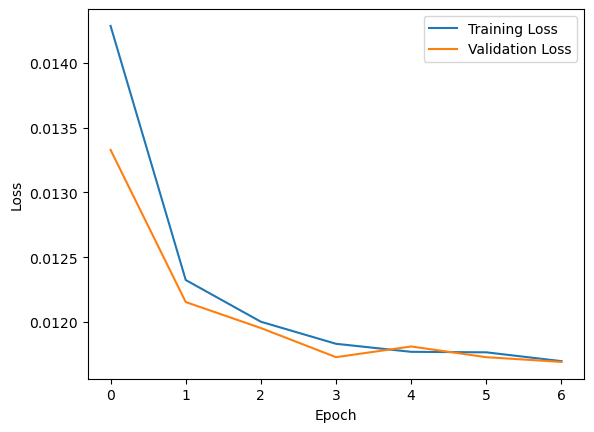

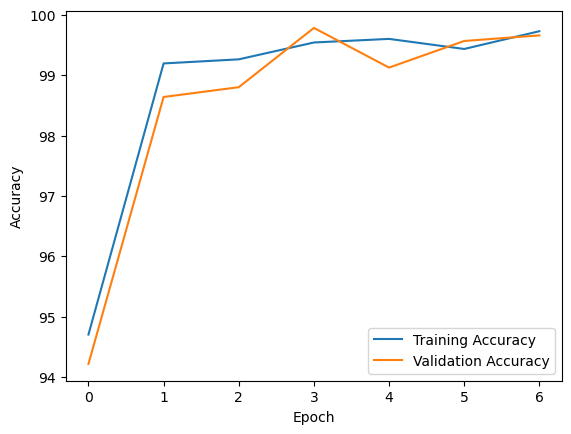

In [24]:
plot_losses(train_losses, val_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [25]:
test_loss, test_accuracy = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.0117, Test Accuracy: 99.62%


In [26]:
def save_model(model, hparams):
    os.makedirs(hparams.model_path, exist_ok=True)

    model_name = model.__class__.__name__ + '_' + datetime.now().strftime("%Y_%m_%d-%H_%M_%S" + '.pt')

    try:
        torch.save(model.state_dict(), os.path.join(hparams.model_path, model_name))
        return True
    except:
        return False

In [27]:
save_model(model, hparams)

True

In [28]:
predictions, labels = predict(model, test_loader, criterion, device, eval=False)

In [29]:
conf_mat = confusion_matrix(labels, predictions)
class_to_idx = list(train_loader.dataset.subset.dataset.class_to_idx)
df_cm = pd.DataFrame(conf_mat, index = class_to_idx, columns = class_to_idx)

<Axes: >

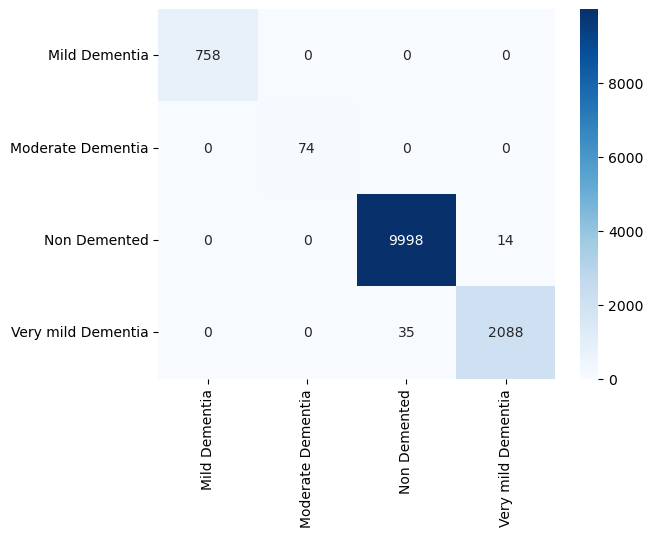

In [30]:
sn.heatmap(df_cm, annot=True, fmt='', cmap='Blues')

In [31]:
print(classification_report(labels, predictions, target_names=class_to_idx))

                    precision    recall  f1-score   support

     Mild Dementia       1.00      1.00      1.00       758
 Moderate Dementia       1.00      1.00      1.00        74
      Non Demented       1.00      1.00      1.00     10012
Very mild Dementia       0.99      0.98      0.99      2123

          accuracy                           1.00     12967
         macro avg       1.00      1.00      1.00     12967
      weighted avg       1.00      1.00      1.00     12967

